In [1]:
import cptac
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats 

cptac warning: Your version of cptac (0.8.8) is out-of-date. Latest is 0.9.0. Please run 'pip install --upgrade cptac' to update it. (<ipython-input-1-0abb492b9562>, line 1)


In [2]:
cptac.download(dataset="Brca")
br = cptac.Brca()

protein_data = br.get_proteomics()

#The dataframes are MultIndex pandas dataframes. 
#However, to teach the basics of pandas, we will remove the "multi" part of the dataframe.
protein_data = protein_data.droplevel(1, axis=1)

rna_data = br.get_transcriptomics()
clinical_data = br.get_clinical()

In [3]:
# print(rna_data)
# print(protein_data)

In [4]:
clinical_data["Age_in_years"] = clinical_data["Age.in.Month"]/12 #fill in with correct math

In [5]:
#Step 2: Find the genes that are in the both protein_data and rna_data

#There are NA's in the protein_data and rna_data
#We will just drop any genes (columns) that have NA's
protein_data.dropna(inplace=True, axis=1 )
rna_data.dropna(inplace=True, axis=1 )

#There are repeated genes in the protein data. Get unique ones.
unique_genes = np.intersect1d( rna_data.columns, protein_data.columns )


#Getting the genes that are significantly differentially expressed
deseq2_results = pd.read_csv("DESeq_Results_Final_Proj.csv")
deseq2_results.dropna(inplace=True)
sig_diff_mask = deseq2_results["pvalue"] < 0.05
sig_diff = deseq2_results[sig_diff_mask]["gene_symbol"]

In [6]:
unique_genes = np.intersect1d(rna_data.columns, protein_data.columns)
protein_data_genes = protein_data.loc[:, unique_genes]
rna_data_genes = rna_data.loc[:, list(protein_data_genes.columns)]

#Separate categories by age 
young_mask = clinical_data["Age_in_years"] <= 40.0
old_mask = clinical_data["Age_in_years"] >= 60.0

#Separating the data by young and old (getting rid of rows)
rna_genes_young = rna_data_genes[ young_mask ]
protein_genes_young = protein_data_genes[ young_mask ]
rna_genes_old = rna_data_genes[ old_mask ]
protein_genes_old = protein_data_genes[ old_mask ]

#Of these gene lists, get the ones that are differentially expressed
pdyi_mask = np.intersect1d(protein_genes_young.columns, sig_diff)
rdyi_mask = np.intersect1d(rna_genes_young.columns, sig_diff)

pdoi_mask = np.intersect1d(protein_genes_old.columns, sig_diff)
rdoi_mask = np.intersect1d(rna_genes_old.columns, sig_diff)


protein_genes_young = protein_genes_young.loc[:, pdyi_mask]
rna_genes_young = rna_genes_young.loc[:, rdyi_mask]

protein_data_old = protein_genes_old.loc[:, pdoi_mask]
rna_data_old = rna_genes_old.loc[:, rdoi_mask]

# Sanity checking 
print(len(protein_genes_young.columns))
print(len(rna_genes_young.columns))
print(len(protein_genes_old.columns))
print(len(rna_genes_old.columns))

1353
1353
5870
5870


In [7]:
#Step 3: Calculate the Spearman correlations

subset = 50;
n_old = 50 #len(protein_genes_old.columns) #fill in with the dimension of one axis. The graph is square.
n_young = 50 #len(protein_genes_young.columns)
final_graph_old = np.zeros( (n_old,n_old) )
final_graph_young = np.zeros( (n_young,n_young) )
old_subset = np.random.choice(protein_genes_old.columns.values, 50, replace=False)
young_subset = np.random.choice(protein_genes_young.columns.values, 50, replace=False)


for i, geneA in enumerate(young_subset):
# protein_genes_young.columns ):
    graph_row_young = []
    for j, geneB in enumerate( young_subset ):
        # rna_genes_young.columns ):

        rho_young, spear_pvalue_young = stats.spearmanr( rna_genes_young.iloc[:,i], protein_genes_young.iloc[:,j])
        graph_row_young.append(rho_young)
    
    final_graph_young[i,:] = graph_row_young

for i, geneA in enumerate( old_subset ):
# protein_genes_old.columns ):

    graph_row_old = []
    for j, geneB in enumerate( old_subset ):
        # rna_genes_old.columns ):
        
        rho_old, spear_pvalue_old = stats.spearmanr( rna_genes_old.iloc[:,i], protein_genes_old.iloc[:,j])
        graph_row_old.append(rho_old)
    
    final_graph_old[i,:] = graph_row_old

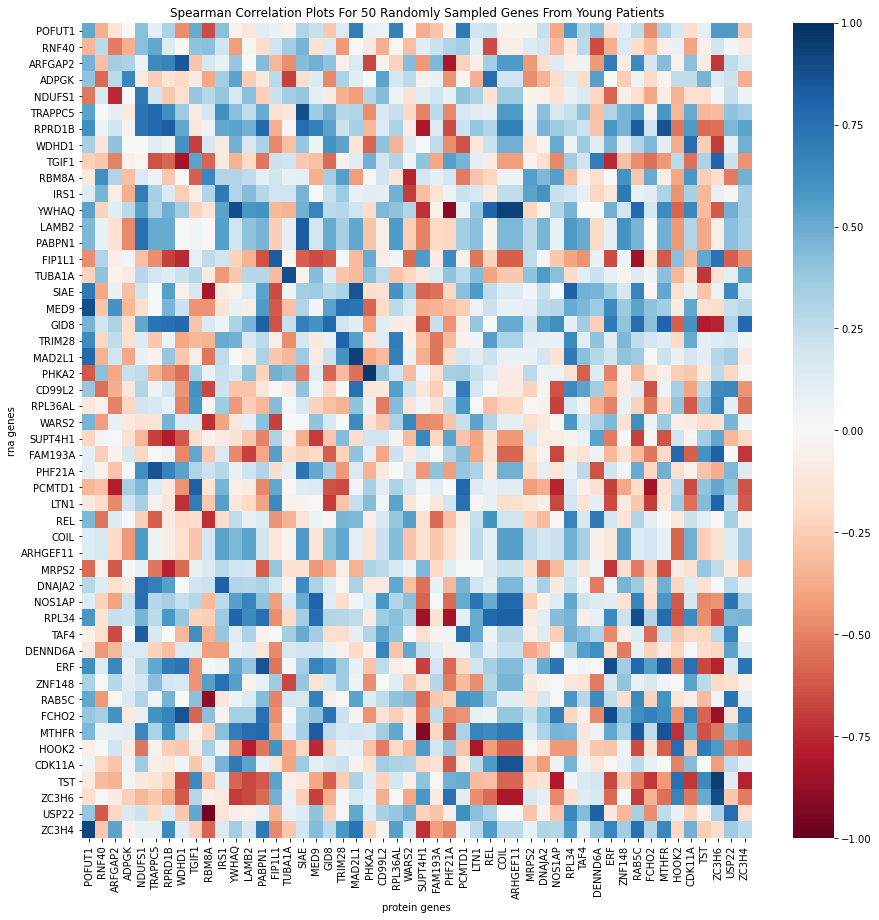

In [12]:
#Creating the Young Heatmap

spearman_young = plt.figure(figsize=(15,15))
ax_spear_young = sns.heatmap(final_graph_young, cmap='RdBu', xticklabels=young_subset, \
                                                yticklabels=young_subset, center=0, vmin=-1, vmax=1)
plt.title("Spearman Correlation Plots For 50 Randomly Sampled Genes From Young Patients")
ax_spear_young.set_ylabel("rna genes")
ax_spear_young.set_xlabel("protein genes")
#plt.show()
plt.savefig("spearman_young.png", bbox_inches="tight") #Use to save figure if running full script

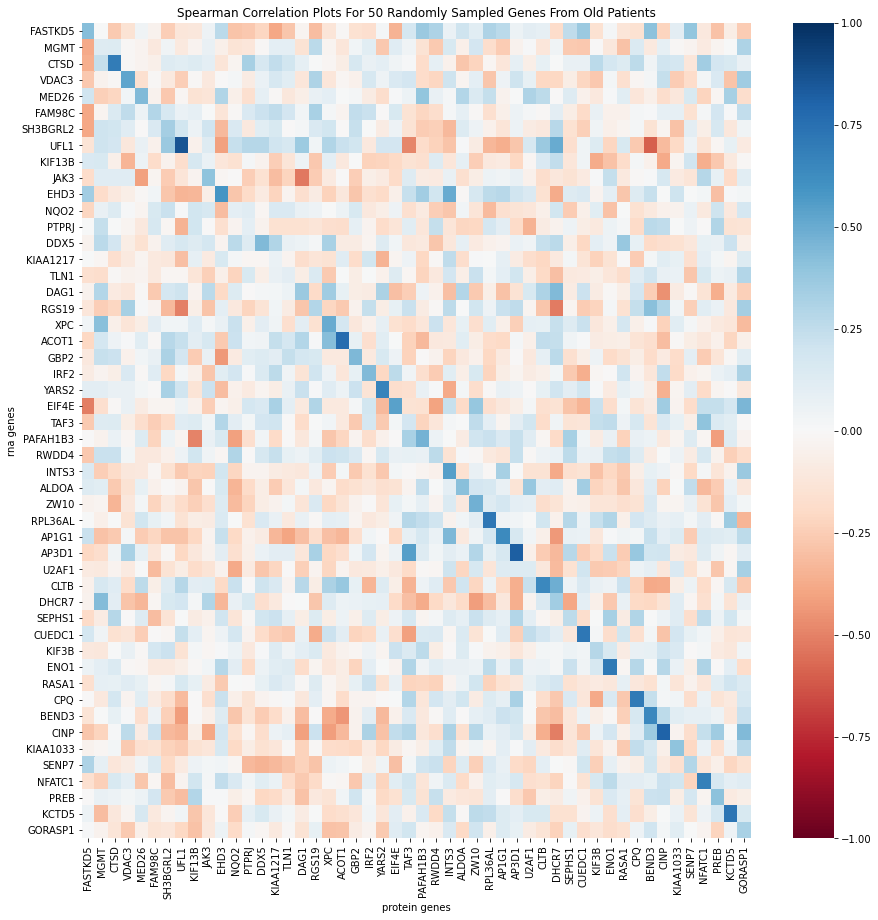

In [13]:
#Creating the Old Heatmap

plt.figure(figsize=(15,15))
ax_spear_old = sns.heatmap(final_graph_old, cmap='RdBu', xticklabels=old_subset, \
                                                yticklabels=old_subset, center=0, vmin=-1, vmax=1)

plt.title("Spearman Correlation Plots For 50 Randomly Sampled Genes From Old Patients")
ax_spear_old.set_ylabel("rna genes")
ax_spear_old.set_xlabel("protein genes")
#plt.show()
plt.savefig("spearman_old.png", bbox_inches="tight") #Use to save figure if running full script